In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.models import load_model
import os
import sys
sys.path.append('../')
from utils import *

# Parameters
n_splits = 4
n_samples = [1000, 2000, 4000, 8000, 16000, 32000, 64000]
discretizations = ['input_25_50', 'input_10_25_50', 'input_50']

# Define colors, markers, and linestyles for plotting
plot_styles = {
    'input_20_30': {'color': 'blue', 'marker': 'o', 'linestyle': '-', 'label': 'input_20-30'},
    'input_15_20_30': {'color': 'blue', 'marker': 's', 'linestyle': '--', 'label': 'input_15-20-30'},
    'input_30': {'color': 'red', 'marker': 'o', 'linestyle': '-', 'label': 'input_30'},
    '25_no_level0': {'color': 'red', 'marker': 's', 'linestyle': '--', 'label': '25-points resolution (No level fusion)'}
}

# Initialize dictionary to store RMSE results
rmse_test_single =[]
rmse_test_all = {disc: [] for disc in discretizations}

# Load training and test data for each discretization
X_train, y_train, X_test, y_test = prepare_data_single_fidelity(
    115200,
    f"../data/data/X_train_h1_100_01.csv",
    f"../data/data/y_train_h1_100_01.csv",
    f"../data/data/X_test_h1_100_01.csv",
    f"../data/data/y_test_h1_100_01.csv"
)

for n_sample in n_samples:
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    X, y = X_train[:n_sample, :], y_train[:n_sample, :]
    rmse_test = []
    predictions_train = []
    predictions_test = []

    
    for fold_var, (train_index, val_index) in enumerate(kf.split(y), start=1):
        X_val_k = X[val_index,:]
        y_val_k = y[val_index]

        # Load model and evaluate RMSE
        model_path = f'../models/single_fidelity_100/resolution_100/samples_{n_sample}/model_fold_{fold_var}.keras'
        model = load_model(model_path)
        rmse_test.append(np.sqrt(np.mean((model(X_val_k).numpy() - y_val_k) ** 2)))

    rmse_test_single.append(rmse_test)
    

# Iterate over each discretization level
for discretization in discretizations:
    print(f"Processing discretization level: {discretization}")
    
    for n_sample in n_samples:

        # Prepare data
        if discretization == 'input_50':
            X_train_param, X_train_coarse1, y_train = prepare_data_multi_fidelity(
                       n_sample,
                       "../data/data/y_train_h1_100_01.csv",
                       "../data/data/X_train_h1_100_01.csv",
                       "../data/data/y_train_h2_100_01.csv"
                    )
            X_inputs = [X_train_param, X_train_coarse1]
        # Prepare data
        elif discretization == 'input_25_50':
            X_train_param, X_train_coarse1, X_train_coarse2, y_train = prepare_data_multi_fidelity(
                       n_sample,
                       "../data/data/y_train_h1_100_01.csv",
                       "../data/data/X_train_h1_100_01.csv",
                       "../data/data/y_train_h2_100_01.csv",
                       "../data/data/y_train_h3_100_01.csv"
                    )
            X_inputs = [X_train_param, X_train_coarse1, X_train_coarse2]
        elif discretization == 'input_10_25_50':
            X_train_param, X_train_coarse1, X_train_coarse2, X_train_coarse3, y_train = prepare_data_multi_fidelity(
                       n_sample,
                       "../data/data/y_train_h1_100_01.csv",
                       "../data/data/X_train_h1_100_01.csv",
                       "../data/data/y_train_h2_100_01.csv",
                       "../data/data/y_train_h3_100_01.csv",
                       "../data/data/y_train_h4_100_01.csv"
                    )
            X_inputs = [X_train_param, X_train_coarse1, X_train_coarse2, X_train_coarse3]

        # Perform k-fold cross-validation
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=56)
        rmse_test = []

        for fold_var, (train_index, val_index) in enumerate(kf.split(y_train), start=1):
            X_val_k = [X[val_index] for X in X_inputs]
            y_val_k = y_train[val_index]

            # Load model and compute RMSE
            model_path = f"../models/multi_fidelity_100/{discretization}/samples_{n_sample}/model_fold_{fold_var}.keras"
            model = load_model(model_path)
            rmse = np.sqrt(np.mean((model(X_val_k).numpy() - y_val_k) ** 2))
            rmse_test.append(rmse)

        # Store RMSE results for the current sample size and discretization
        rmse_test_all[discretization].append(rmse_test)



Processing discretization level: input_25_50
Processing discretization level: input_10_25_50
Processing discretization level: input_50


In [8]:
print(rmse_test_all)

{'input_25_50': [[0.0018731461660060858, 0.0019376773735734502, 0.0018728677411013292, 0.00185468977331333], [0.0013363451658127703, 0.0013169457802963615, 0.0013753535941365277, 0.0012847018357683845], [0.0007711246749677791, 0.0007637671453614218, 0.0007704736223497533, 0.0007635328899175363], [0.00036641803710455654, 0.0003733108621880431, 0.0003758027374099659, 0.0003711887624094383], [0.00029590277419515423, 0.00029566902089040424, 0.0002875513887830527, 0.0003018393556595077], [0.00026071707453181355, 0.00026216832921023515, 0.00025991475994744816, 0.00026072068225302543], [0.00023689621571227088, 0.00024474612308937783, 0.00024373481504495712, 0.0002436503959361255]], 'input_10_25_50': [[0.0030220677998354143, 0.0027905687854390075, 0.003003241366645894, 0.002865727013494225], [0.0011037575319441664, 0.001084638554830249, 0.0010897564374918618, 0.0010413986092962237], [0.0005761268743533184, 0.0005610526600466154, 0.0005615391007243321, 0.0005559257187127541], [0.000319405886770

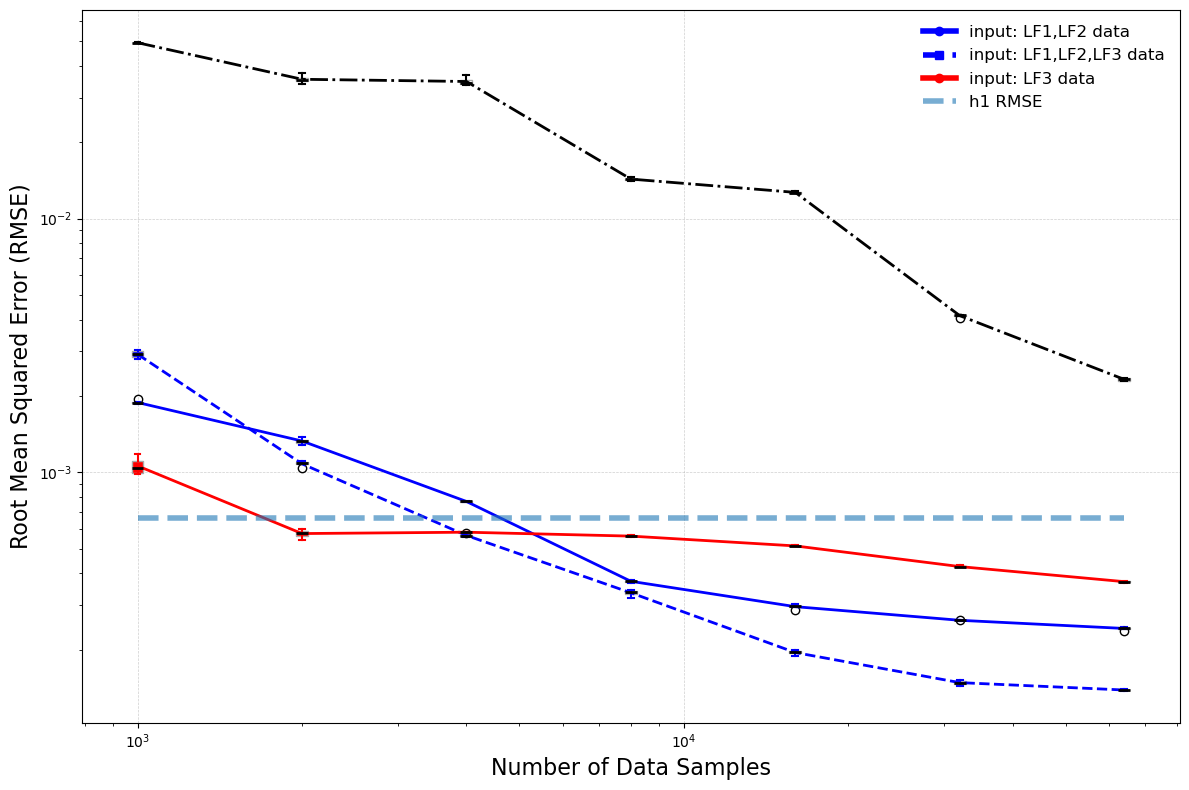

In [9]:
# Define colors, markers, and linestyles for plotting
plot_styles = {
    'input_25_50': {'color': 'blue', 'marker': 'o', 'linestyle': '-', 'label': 'input: LF1,LF2 data'},
    'input_10_25_50': {'color': 'blue', 'marker': 's', 'linestyle': '--', 'label': 'input: LF1,LF2,LF3 data'},
    'input_50': {'color': 'red', 'marker': 'o', 'linestyle': '-', 'label': 'input: LF3 data'},
    '25_no_level0': {'color': 'red', 'marker': 's', 'linestyle': '--', 'label': '25-points resolution (No level fusion)'}
}
# # Plotting results
plt.figure(figsize=(12, 8))

# Create custom legend lines for plotting
custom_lines = [
    plt.Line2D([0], [0], color=plot_styles[d]['color'], lw=4, linestyle=plot_styles[d]['linestyle'], marker=plot_styles[d]['marker'])
    for d in discretizations
]

# Calculate a consistent width for boxplots relative to the x-axis range
x_range = np.log10(max(n_samples)) - np.log10(min(n_samples))
fixed_width = 0.1 * x_range  # Adjust this factor as needed for ideal width

plt.boxplot(
    rmse_test_single,
    positions=n_samples,
    widths=np.array(n_samples)*0.05,  # Apply consistent width
    patch_artist=True,
    boxprops=dict(facecolor='white', edgecolor='darkgray', linewidth=1),
    medianprops=dict(color='black', linewidth=2),
    whiskerprops=dict(color='black', linewidth=1.5),
    capprops=dict(color='black', linewidth=1.5),
    showfliers=True
)

# Generate boxplots for each discretization level and sample size
for discretization in discretizations:
    plt.boxplot(
        rmse_test_all[discretization],
        positions=n_samples,
        widths=np.array(n_samples)*0.05,  # Apply consistent width
        patch_artist=True,
        boxprops=dict(facecolor=plot_styles[discretization]['color'], edgecolor='darkgray', linewidth=1),
        medianprops=dict(color='black', linewidth=2),
        whiskerprops=dict(color=plot_styles[discretization]['color'], linewidth=1.5),
        capprops=dict(color=plot_styles[discretization]['color'], linewidth=1.5),
        showfliers=True
    )

mean_rmse = [np.mean(rmse_list) for rmse_list in rmse_test_single]

single = plt.plot(n_samples, mean_rmse, color='black', linestyle="-.", marker=None, linewidth=2, markersize=8)


# Plot convergence lines for each discretization level
for discretization in discretizations:
    mean_rmse = [np.mean(rmse_list) for rmse_list in rmse_test_all[discretization]]
    plt.plot(n_samples, mean_rmse, color=plot_styles[discretization]['color'], linestyle=plot_styles[discretization]['linestyle'], marker=None, linewidth=2, markersize=8)

b=plt.plot(n_samples, 6.6e-4*np.ones((len(n_samples),1)), linestyle='--', linewidth=4, alpha=0.6)
# Final plot adjustments
plt.xlabel('Number of Data Samples', fontsize=16)
plt.ylabel('Root Mean Squared Error (RMSE)', fontsize=16)
plt.legend(custom_lines+b, [plot_styles[d]['label'] for d in discretizations] + ["h1 RMSE"], loc='upper right', fontsize=12, frameon=False)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.yscale('log')
plt.xscale('log')

# Save plot to file
plt.tight_layout()
plt.savefig("../images/convergence_error_multi_fidelity.png", dpi=600, bbox_inches='tight')

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.models import load_model
import os
import sys
sys.path.append('../')
from utils import *

# Parameters
n_splits = 4
n_samples = [1000, 2000, 4000, 8000, 16000, 32000, 64000]
discretizations = ['10', '10_2step', '25', '25_2step']

# Define colors, markers, and linestyles for plotting
plot_styles = {
    '10': {'color': 'blue', 'marker': 'o', 'linestyle': '-', 'label': '10-points resolution'},
    '10_no_level0': {'color': 'blue', 'marker': 's', 'linestyle': '--', 'label': '10-points resolution (No level fusion)'},
    '25': {'color': 'red', 'marker': 'o', 'linestyle': '-', 'label': '25-points resolution'},
    '25_no_level0': {'color': 'red', 'marker': 's', 'linestyle': '--', 'label': '25-points resolution (No level fusion)'}
}

# Initialize dictionary to store RMSE results
rmse_test_single =[]
rmse_test_all = {disc: [] for disc in discretizations}

# Load training and test data for each discretization
X_train, y_train, X_test, y_test = prepare_data_single_fidelity(
    115200,
    f"../data/X_train_h1.csv",
    f"../data/y_train_h1.csv",
    f"../data/X_test_h1.csv",
    f"../data/y_test_h1.csv"
)

for n_sample in n_samples:
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    X, y = X_train[:n_sample, :], y_train[:n_sample, :]
    rmse_test = []
    predictions_train = []
    predictions_test = []

    
    for fold_var, (train_index, val_index) in enumerate(kf.split(y), start=1):
        X_val_k = X[val_index,:]
        y_val_k = y[val_index]

        # Load model and evaluate RMSE
        model_path = f'../models/single_fidelity/resolution_h1/samples_{n_sample}/model_fold_{fold_var}.keras'
        model = load_model(model_path)
        rmse_test.append(np.sqrt(np.mean((model(X_val_k).numpy() - y_val_k) ** 2)))

    rmse_test_single.append(rmse_test)
    

# Iterate over each discretization level
for discretization in discretizations:
    print(f"Processing discretization level: {discretization}")
    
    for n_sample in n_samples:
        has_level0 = 'step' not in discretization

        # Define file paths for training and testing data
        data_paths = {
            'y_train': "../data/y_train_h1.csv",
            'X_train_param': "../data/X_train_h1.csv",
            'y_test': "../data/y_test_h1.csv",
            'X_test_param': "../data/X_test_h1.csv"
        }

        if discretization in ['10', '25']:
            data_paths.update({
                'X_train_nn': f"../data/predictions_single_fidelity/resolution_h1/samples_{n_sample}/predictions_train.csv",
                'X_train_coarse': f"../data/y_train_h{3 if discretization == '10' else 2}.csv",
                'X_test_nn': f"../data/predictions_single_fidelity/resolution_h1/samples_{n_sample}/predictions_test.csv",
                'X_test_coarse': f"../data/y_test_h{3 if discretization == '10' else 2}.csv"
            })
        else:
            data_paths.update({
                'X_train_nn': f"../data/predictions_single_fidelity/resolution_h1/samples_{n_sample}/predictions_train.csv",
                'X_train_coarse': f"../data/predictions_single_fidelity/resolution_h{3 if '10' in discretization else 2}/samples_64000/predictions_train.csv",
                'X_test_nn': f"../data/predictions_single_fidelity/resolution_h1/samples_{n_sample}/predictions_test.csv",
                'X_test_coarse': f"../data/predictions_single_fidelity/resolution_h{3 if '10' in discretization else 2}/samples_64000/predictions_test.csv",
            })

        # Prepare data
        if has_level0:
            X_train_param, X_train_coarse, X_train_nn, y_train = prepare_data_multi_fidelity(
                n_sample,
                data_paths['y_train'],
                data_paths['X_train_param'],
                data_paths['X_train_coarse'],
                data_paths['X_train_nn']
            )
            X_inputs = [X_train_param, X_train_coarse, X_train_nn]
        else:
            X_train_param, X_train_coarse, X_train_nn, y_train = prepare_data_multi_fidelity(
                n_sample,
                data_paths['y_train'],
                data_paths['X_train_param'],
                data_paths['X_train_coarse'],
                data_paths['X_train_nn']
            )
            X_inputs = [X_train_param, X_train_coarse, X_train_nn]

        # Perform k-fold cross-validation
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=56)
        rmse_test = []

        for fold_var, (train_index, val_index) in enumerate(kf.split(y_train), start=1):
            X_val_k = [X[val_index] for X in X_inputs]
            y_val_k = y_train[val_index]

            # Load model and compute RMSE
            model_path = f"../models/multi_fidelity/resolution_50-{discretization}/samples_{n_sample}/model_fold_{fold_var}.keras"
            model = load_model(model_path)
            rmse = np.sqrt(np.mean((model(X_val_k).numpy() - y_val_k) ** 2))
            rmse_test.append(rmse)

        # Store RMSE results for the current sample size and discretization
        rmse_test_all[discretization].append(rmse_test)



FileNotFoundError: ../data/X_train_h1.csv not found.

In [ ]:
plot_styles = {
    '10': {'color': 'blue', 'marker': 'o', 'linestyle': '-', 'label': '$h_3=0.1$ resolution, 1step'},
    '10_2step': {'color': 'blue', 'marker': 's', 'linestyle': '--', 'label': '$h_3=0.1$ resolution, 2step'},
    '25': {'color': 'red', 'marker': 'o', 'linestyle': '-', 'label': '$h_2=0.04 resolution$, 1step'},
    '25_2step': {'color': 'red', 'marker': 's', 'linestyle': '--', 'label': '$h_2=0.04$ resolution, 2step'}
}
# Plotting results
plt.figure(figsize=(12, 8))

# Create custom legend lines for plotting
custom_lines = [
    plt.Line2D([0], [0], color=plot_styles[d]['color'], lw=4, linestyle=plot_styles[d]['linestyle'], marker=plot_styles[d]['marker'])
    for d in discretizations
]

# Calculate a consistent width for boxplots relative to the x-axis range
x_range = np.log10(max(n_samples)) - np.log10(min(n_samples))
fixed_width = 0.1 * x_range  # Adjust this factor as needed for ideal width

plt.boxplot(
    rmse_test_single,
    positions=n_samples,
    widths=np.array(n_samples)*0.05,  # Apply consistent width
    patch_artist=True,
    boxprops=dict(facecolor='white', edgecolor='darkgray', linewidth=1),
    medianprops=dict(color='black', linewidth=2),
    whiskerprops=dict(color='black', linewidth=1.5),
    capprops=dict(color='black', linewidth=1.5),
    showfliers=True
)

# Generate boxplots for each discretization level and sample size
for discretization in discretizations:
    plt.boxplot(
        rmse_test_all[discretization],
        positions=n_samples,
        widths=np.array(n_samples)*0.05,  # Apply consistent width
        patch_artist=True,
        boxprops=dict(facecolor=plot_styles[discretization]['color'], edgecolor='darkgray', linewidth=1),
        medianprops=dict(color='black', linewidth=2),
        whiskerprops=dict(color=plot_styles[discretization]['color'], linewidth=1.5),
        capprops=dict(color=plot_styles[discretization]['color'], linewidth=1.5),
        showfliers=True
    )

mean_rmse = [np.mean(rmse_list) for rmse_list in rmse_test_single]
single = plt.plot(n_samples, mean_rmse, color='black', linestyle="-.", marker=None, linewidth=2, markersize=8)


# Plot convergence lines for each discretization level
for discretization in discretizations:
    mean_rmse = [np.mean(rmse_list) for rmse_list in rmse_test_all[discretization]]
    plt.plot(n_samples, mean_rmse, color=plot_styles[discretization]['color'], linestyle=plot_styles[discretization]['linestyle'], marker=None, linewidth=2, markersize=8)

# Final plot adjustments
plt.xlabel('Number of Data Samples', fontsize=16)
plt.ylabel('Root Mean Squared Error (RMSE)', fontsize=16)
plt.legend(single+custom_lines, ['Single fidelity']+[plot_styles[d]['label'] for d in discretizations], loc='upper right', fontsize=12, frameon=False)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.yscale('log')
plt.xscale('log')

# Save plot to file
plt.tight_layout()
plt.savefig("../images/convergence_error_multi_fidelity_2step.png", dpi=600, bbox_inches='tight')